<a href="https://colab.research.google.com/github/soGaussian/Try/blob/master/traffic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client(project='mozdata')

In [10]:
def myquery_to_pdf( qry):
  df = client.query(qry).to_dataframe()
  return df


over_all_q = """
SELECT EXTRACT(MONTH FROM date) as month
     #, browser
     , count(distinct visit_identifier) as  total_traffic
     , count(distinct case when event_action = 'Firefox Download' then visit_identifier end) as downloads
     -- , downloads/total_traffic
 FROM `moz-fx-data-marketing-prod.ga_derived.www_site_hits_v1`
 WHERE date >= "2022-01-01"
group by 1
order by 1
"""

all_combined_df = myquery_to_pdf(over_all_q)
all_combined_df

,month,total_traffic,downloads
0,1,93620331,12178660
1,2,91751816,11105109
2,3,96397952,12039102
3,4,90049365,10737848
4,5,97094342,10803613
5,6,101808390,10154853
6,7,94892096,9854810
7,8,83444719,10281160
8,9,30605126,3674570


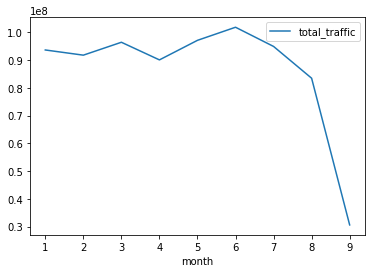

In [11]:
all_combined_df.plot.line(x='month', y='total_traffic')

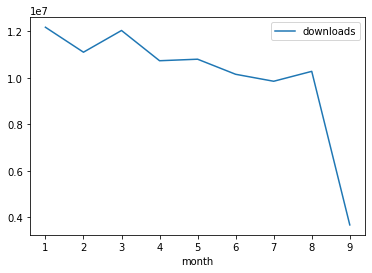

In [12]:
all_combined_df.plot.line(x='month', y='downloads')

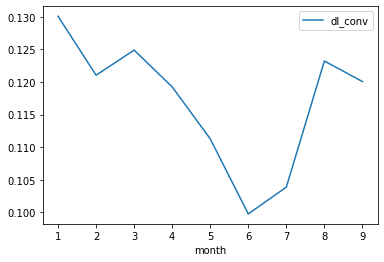

In [13]:
all_combined_df['dl_conv'] = all_combined_df['downloads'] / all_combined_df['total_traffic']
all_combined_df.plot.line(x='month', y='dl_conv')

In [33]:
final_query = """with this_year as (
  SELECT EXTRACT(MONTH FROM date) as month
     -- , browser
     , case when country in ('Canada', 'United States') then 'NA Tier 1' 
            when country in ('United Kingdom', 'Germany', 'France') then 'EU Tier 1'
            when country in ('Netherlands', 'Italy', 'Spain', 'Austria', 'Sweden', 'Belgium') then 'EU Expansion'
            else 'other' end as market
     , count(distinct visit_identifier) as  total_traffic
     , count(distinct case when event_action = 'Firefox Download' then visit_identifier end) as downloads
     , count(distinct case when browser = 'Chrome' then visit_identifier end) as chrome_traffic
     , count(distinct case when browser = 'Chrome' and event_action = 'Firefox Download' then visit_identifier end) as chrome_downloads
     , count(distinct case when browser = 'Firefox' then visit_identifier end) as firefox_traffic
     , count(distinct case when browser = 'Firefox' and event_action = 'Firefox Download' then visit_identifier end) as firefox_downloads
     , count(distinct case when browser = 'Edge' then visit_identifier end) as edge_traffic
     , count(distinct case when browser = 'Edge' and event_action = 'Firefox Download' then visit_identifier end) as edge_downloads
     , count(distinct case when browser = 'Safari' then visit_identifier end) as safari_traffic
     , count(distinct case when browser = 'Safari' and event_action = 'Firefox Download' then visit_identifier end) as safrai_downloads
     , count(distinct case when browser not in ('Edge', 'Chrome', 'Firefox', 'Safari') then visit_identifier end) as other_traffic
     , count(distinct case when browser not in ('Edge', 'Chrome', 'Firefox', 'Safari') and event_action = 'Firefox Download' then visit_identifier end) as other_downloads
 FROM `moz-fx-data-marketing-prod.ga_derived.www_site_hits_v1` 
 WHERE date between "2022-01-01" and "2022-08-31"
-- and page_path like '%www.mozilla.org%' -- and event_action = 'Firefox Download'
group by 1 , 2
order by 2, 1
)
, last_year as (SELECT EXTRACT(MONTH FROM date) as month
     -- , browser
     , case when country in ('Canada', 'United States') then 'NA Tier 1' 
            when country in ('United Kingdom', 'Germany', 'France') then 'EU Tier 1'
            when country in ('Netherlands', 'Italy', 'Spain', 'Austria', 'Sweden', 'Belgium') then 'EU Expansion'
            else 'other' end as market
     , count(distinct visit_identifier) as  total_traffic
     , count(distinct case when event_action = 'Firefox Download' then visit_identifier end) as downloads
     , count(distinct case when browser = 'Chrome' then visit_identifier end) as chrome_traffic
     , count(distinct case when browser = 'Chrome' and event_action = 'Firefox Download' then visit_identifier end) as chrome_downloads
     , count(distinct case when browser = 'Firefox' then visit_identifier end) as firefox_traffic
     , count(distinct case when browser = 'Firefox' and event_action = 'Firefox Download' then visit_identifier end) as firefox_downloads
     , count(distinct case when browser = 'Edge' then visit_identifier end) as edge_traffic
     , count(distinct case when browser = 'Edge' and event_action = 'Firefox Download' then visit_identifier end) as edge_downloads
     , count(distinct case when browser = 'Safari' then visit_identifier end) as safari_traffic
     , count(distinct case when browser = 'Safari' and event_action = 'Firefox Download' then visit_identifier end) as safrai_downloads
     , count(distinct case when browser not in ('Edge', 'Chrome', 'Firefox', 'Safari') then visit_identifier end) as other_traffic
     , count(distinct case when browser not in ('Edge', 'Chrome', 'Firefox', 'Safari') and event_action = 'Firefox Download' then visit_identifier end) as other_downloads
 FROM `moz-fx-data-marketing-prod.ga_derived.www_site_hits_v1` 
 WHERE date between "2021-01-01" and "2021-08-31"
-- and page_path like '%www.mozilla.org%' -- and event_action = 'Firefox Download'
group by 1, 2
order by 2, 1
)
select a.*, b.* except(market, month)
     , safe_divide(a.downloads,a.total_traffic) as download_conv
     , safe_divide(a.chrome_downloads,a.chrome_traffic) as chrome_download_conv
     , safe_divide(b.chrome_downloads,b.chrome_traffic) as chrome_download_conv_prev
     , safe_divide(a.firefox_downloads,a.firefox_traffic) as fx_download_conv
     , safe_divide(b.firefox_downloads,b.firefox_traffic) as fx_download_conv_prev
     , safe_divide(a.edge_downloads,a.edge_traffic) as edge_download_conv
     , safe_divide(b.edge_downloads,b.edge_traffic) as edge_download_conv_prev
     , safe_divide(a.other_downloads,a.other_traffic) as ot_download_conv
     , safe_divide(b.other_downloads,b.other_traffic) as ot_download_conv_prev
     , safe_divide(b.downloads,b.total_traffic) as download_conv_prev
     , safe_divide(a.total_traffic,b.total_traffic) as traffic_smt, safe_divide(a.downloads,b.downloads) as downloads_smt
     , safe_divide(a.chrome_traffic,a.total_traffic) as sot_chrome, safe_divide(a.firefox_traffic,a.total_traffic) as sot_fx
     , safe_divide(a.edge_traffic,a.total_traffic) as sot_edge, safe_divide(a.safari_traffic,a.total_traffic) as sot_safari
     , safe_divide(a.other_traffic,a.total_traffic) as sot_other
from this_year a
left join last_year b
       on a.market = b.market
       and a.month = b.month
order by 2, 1
"""

base_df = myquery_to_pdf(final_query)

In [34]:
list(base_df)

['month',
 'market',
 'total_traffic',
 'downloads',
 'chrome_traffic',
 'chrome_downloads',
 'firefox_traffic',
 'firefox_downloads',
 'edge_traffic',
 'edge_downloads',
 'safari_traffic',
 'safrai_downloads',
 'other_traffic',
 'other_downloads',
 'total_traffic_1',
 'downloads_1',
 'chrome_traffic_1',
 'chrome_downloads_1',
 'firefox_traffic_1',
 'firefox_downloads_1',
 'edge_traffic_1',
 'edge_downloads_1',
 'safari_traffic_1',
 'safrai_downloads_1',
 'other_traffic_1',
 'other_downloads_1',
 'download_conv',
 'chrome_download_conv',
 'chrome_download_conv_prev',
 'fx_download_conv',
 'fx_download_conv_prev',
 'edge_download_conv',
 'edge_download_conv_prev',
 'ot_download_conv',
 'ot_download_conv_prev',
 'download_conv_prev',
 'traffic_smt',
 'downloads_smt',
 'sot_chrome',
 'sot_fx',
 'sot_edge',
 'sot_safari',
 'sot_other']

In [ ]:
base_df

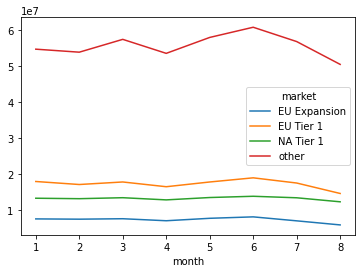

In [26]:
import pandas as pd
traffic_market = pd.pivot(base_df[['month', 'market', 'total_traffic']], index = 'month', columns = 'market', values='total_traffic')
# traffic_market
traffic_market.plot.line()

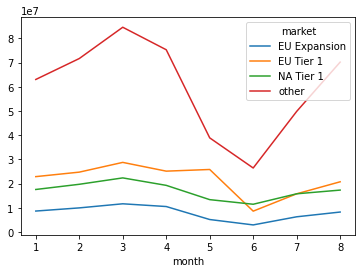

In [35]:
traffic_market_py = pd.pivot(base_df[['month', 'market', 'total_traffic_1']], index = 'month', columns = 'market', values='total_traffic_1')
# traffic_market
traffic_market_py.plot.line()

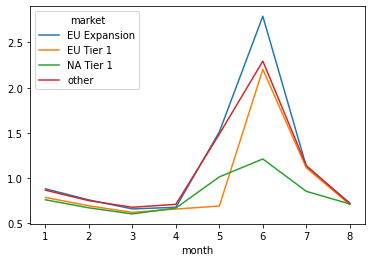

In [36]:
traffic_market_sm = pd.pivot(base_df[['month', 'market', 'traffic_smt']], index = 'month', columns = 'market', values='traffic_smt')
# traffic_market
traffic_market_sm.plot.line()

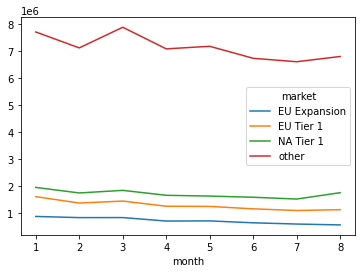

In [37]:
traffic_market = pd.pivot(base_df[['month', 'market', 'downloads']], index = 'month', columns = 'market', values='downloads')
# traffic_market
traffic_market.plot.line()

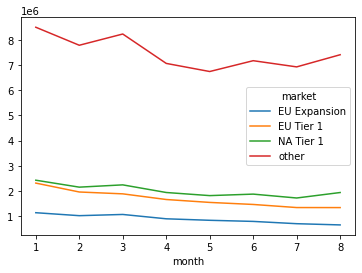

In [38]:
traffic_market = pd.pivot(base_df[['month', 'market', 'downloads_1']], index = 'month', columns = 'market', values='downloads_1')
# traffic_market
traffic_market.plot.line()

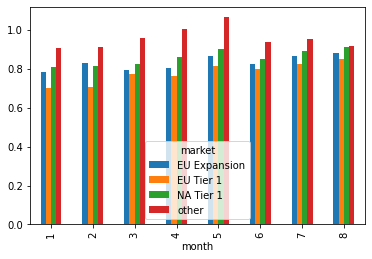

In [32]:
traffic_market = pd.pivot(base_df[['month', 'market', 'downloads_smt']], index = 'month', columns = 'market', values='downloads_smt')
# traffic_market
traffic_market.plot.bar()

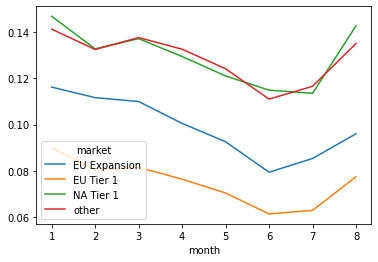

In [40]:
traffic_market = pd.pivot(base_df[['month', 'market', 'download_conv']], index = 'month', columns = 'market', values='download_conv')
# traffic_market
traffic_market.plot.line()

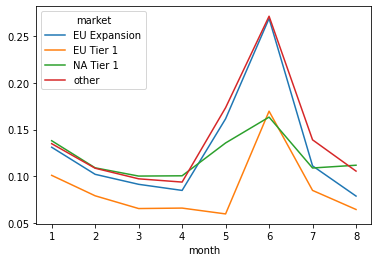

In [41]:
traffic_market = pd.pivot(base_df[['month', 'market', 'download_conv_prev']], index = 'month', columns = 'market', values='download_conv_prev')
# traffic_market
traffic_market.plot.line()

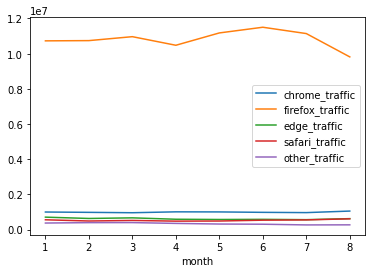

In [59]:
def zoom_marketplace(df, filter_by, cols2plot):
  cols2plot= cols2plot + ['month']
  df = df.loc[df['market'] == filter_by]
  df[cols2plot].set_index('month').plot.line()

zoom_marketplace(base_df, 'NA Tier 1', ['chrome_traffic', 'firefox_traffic', 'edge_traffic', 'safari_traffic', 'other_traffic'])

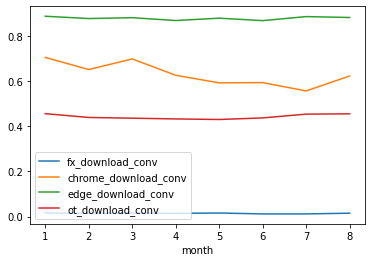

In [61]:
zoom_marketplace(base_df, 'NA Tier 1',['fx_download_conv', 'chrome_download_conv', 'edge_download_conv', 'ot_download_conv'])

In [ ]:
SELECT EXTRACT(MONTH FROM date) as month
     , browser
     , count(distinct visit_identifier) as  total_traffic
     , count(distinct case when event_action = 'Firefox Download' then visit_identifier end) as downloads
 FROM `moz-fx-data-marketing-prod.ga_derived.www_site_hits_v1`
 WHERE date >= "2022-01-01"
and page_path like '%www.mozilla.org%' -- and event_action = 'Firefox Download'
group by 1, 2
order by 2, 1